In [14]:
%matplotlib inline 
import mysql.connector
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from gensim import corpora, models, similarities
import csv
from TrainTest import TrainTest
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS
matplotlib.style.use('ggplot')


In [15]:
#connect to mysql
cnx = mysql.connector.connect(host='152.19.68.141', user='ctolson', password='ilaYOU5!', database='sephora_cosmetics')
cursor = cnx.cursor()

#query reviews by product id
query = ("SELECT R.product_id, review_id, review, type "
         "FROM Reviews as R "
         "JOIN Product as P "
         "ON P.product_id = R.product_id")
cursor.execute(query)

#close mysql server
cnx.close()

In [16]:
#clean reviews data
product_id = []
review_id = []
reviews = []
types = []
for (x, y, z, w) in cursor:
    product_id.append(int(x))
    review_id.append(int(y))
    reviews.append(z)
    types.append(w)
    
#convert to data frame
data = list(zip(product_id, review_id, reviews, types))
review_data = pd.DataFrame(data=data, index=range(0,len(reviews)), columns=['product_id', 'review_id', 'reviews', 'types'])


In [17]:
#get training set review ids
training = TrainTest()
ttset = training.getSet()
train = ttset['train']

#create training set
review_train = review_data.loc[review_data['review_id'].isin(train)]

#group by product_id
reviews = review_train.groupby('product_id')['reviews'].apply(lambda x: "{%s}" % ', '.join(x))
product_id = review_train.groupby('product_id')['product_id'].first()
types = review_train.groupby('product_id')['types'].first()

#convert series to lists
reviews = reviews.tolist()
product_id = product_id.tolist()


In [18]:
#tokenizer function
def stemTokenizer(text):
    #set stop words 
    stop_words = set(stopwords.words('english'))
    stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}']) # remove it if you need punctuation 
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stop_words]
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]     
            
    #stem tokens
    sb_stemmer = SnowballStemmer("english")
    stemmed_tokens = [sb_stemmer.stem(i) for i in filtered_tokens]
    
    return stemmed_tokens

#get tokens
stemmed_tokens = [stemTokenizer(x) for x in reviews]



In [46]:
#build bag of words
dictionary = corpora.Dictionary(stemmed_tokens)
dict_corpus = [dictionary.doc2bow(text) for text in stemmed_tokens]
corpora.MmCorpus.serialize('~/Desktop/model_corpus.mm', dict_corpus)
model_corpus = corpora.MmCorpus('~/Desktop/model_corpus.mm')
num = model_corpus.num_terms

In [47]:
#tf-idf model
tfidf = models.TfidfModel(model_corpus)
model_corpus = tfidf[model_corpus]

#lda model
#lda = models.ldamodel.LdaModel(model_corpus, num_topics=5, id2word = dictionary, passes=20)
#model_corpus = lda[model_corpus]

#lsi model
lsi = models.LsiModel(model_corpus, num_topics=5, id2word=dictionary)
model_corpus = lsi[model_corpus]
num=100

#get cosine similarity
index = similarities.MatrixSimilarity(model_corpus, num_features=num)


In [48]:
#open file 
fl = open('../../Data/dist_reviews_lsi.csv', 'w')
writer = csv.writer(fl)
writer.writerow(['product_id']+product_id)

#find distances
count = 0
for sims in index:
  
    #save similarties
    dist = [x for x in sims]
    dist = [product_id[count]]+dist
    writer.writerow(dist)
    count = count+1

#close file
fl.close()  


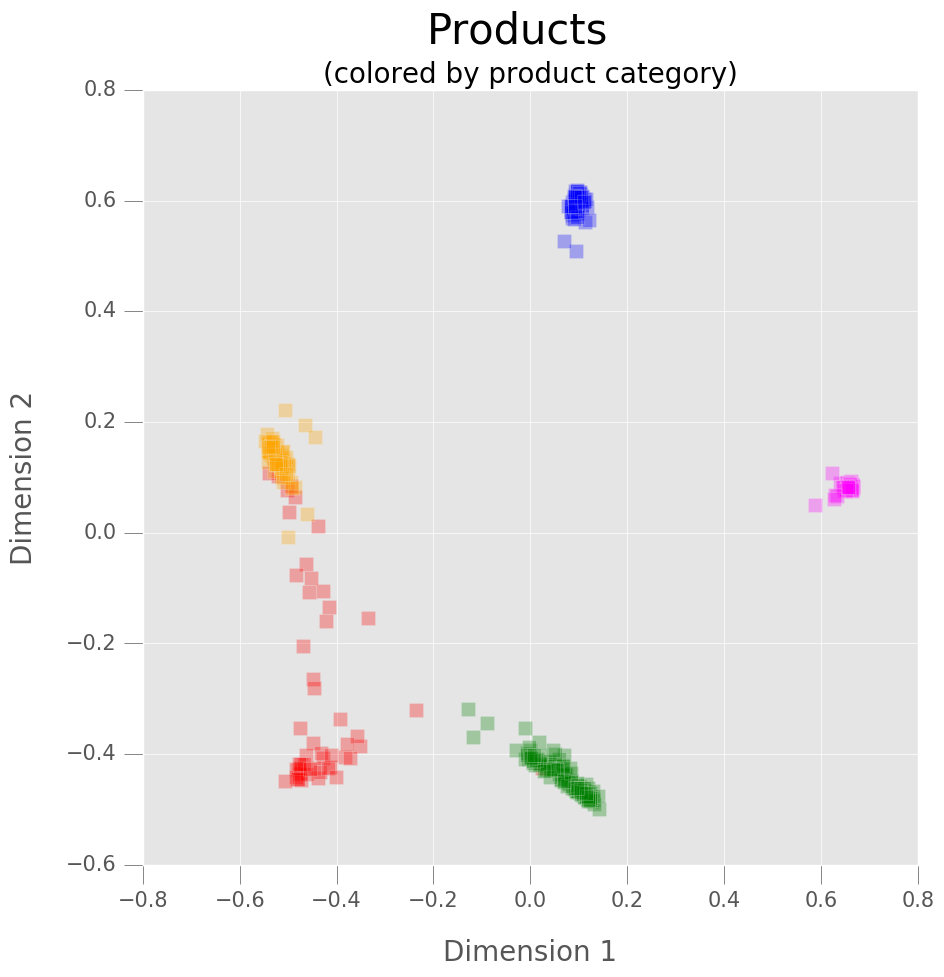

In [49]:
#read in data
d = []
for sims in index:
    d.append([float("{0:.2f}".format(1-x)) for x in sims])
    
#multi-dimensional scaling
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(d)  
xs, ys = pos[:, 0], pos[:, 1]

#color by cluster
color = search_topics = ['red','blue','green','orange','magenta']   
typeclass, typeind = np.unique(types, return_inverse=True)

#plot MDS
fig, ax = plt.subplots(figsize=(10,10))
for i in range(0, len(xs)):
    col = color[typeind[i]]
    scatter = ax.scatter(np.array(xs[i]), np.array(ys[i]), c=col, s=100, alpha=0.3, marker='s')
    
plt.xlabel('Dimension 1', fontsize=20, labelpad=20)
plt.ylabel('Dimension 2', fontsize=20, labelpad=20)
plt.suptitle('Products', fontsize=30)
plt.title('(colored by product category)', fontsize=20)
plt.tick_params(labelsize=15, length=14, direction='out', pad=15, top='off', right='off')

#show figure
plt.show()
        